In [1]:
import pandas as pd
import numpy as np
import yfinance as yf
from scipy import stats
import yfinance as yf
from itertools import combinations
from datetime import datetime

from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import make_scorer
from sklearn.model_selection import GridSearchCV
import warnings
warnings.filterwarnings('ignore')


In [2]:
def analyze_etf_correlations(etf_symbols, start_date, end_date, correlation_threshold=0.8):
    # Download historical data for all ETFs
    data = pd.DataFrame()
    for symbol in etf_symbols:
        try:
            etf_data = yf.download(symbol, start=start_date, end=end_date)['Adj Close']
            data[symbol] = etf_data
        except Exception as e:
            print(f"Error downloading {symbol}: {e}")
    
    # Calculate returns
    returns = data.pct_change().dropna()
    
    # Calculate correlation matrix
    corr_matrix = returns.corr()
    
    # Find highly correlated pairs
    highly_correlated = []
    for etf1, etf2 in combinations(etf_symbols, 2):
        correlation = corr_matrix.loc[etf1, etf2]
        if correlation >= correlation_threshold:
            highly_correlated.append({
                'ETF1': etf1,
                'ETF2': etf2,
                'Correlation': correlation
            })
    
    return pd.DataFrame(highly_correlated).sort_values('Correlation', ascending=False)

# Example usage
etfs = [
    'SPY',  # S&P 500
    'QQQ',  # Nasdaq 100
    'IWM',  # Russell 2000
    'EFA',  # MSCI EAFE
    'EEM',  # MSCI Emerging Markets
    'GLD',  # Gold
    'TLT',  # 20+ Year Treasury Bond
    'VNQ',  # Real Estate
]

start_date = '2020-01-01'
end_date = datetime.today().strftime('%Y-%m-%d')

results = analyze_etf_correlations(etfs, start_date, end_date)
print("\nHighly correlated ETF pairs:")
print(results.to_string(index=False))

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


Highly correlated ETF pairs:
ETF1 ETF2  Correlation
 SPY  QQQ     0.930378
 SPY  EFA     0.873975
 SPY  IWM     0.866843
 EFA  EEM     0.840547
 IWM  EFA     0.833156
 SPY  VNQ     0.808039
 IWM  VNQ     0.806094


In [34]:
from scipy import stats
import matplotlib.pyplot as plt
import seaborn as sns

class PairsTrader:
    def __init__(self, symbol1, symbol2, start_date, end_date,
                 entry_threshold=2.0, exit_threshold=0.0,
                 lookback_period=30):
        self.symbol1 = symbol1
        self.symbol2 = symbol2
        self.entry_threshold = entry_threshold
        self.exit_threshold = exit_threshold
        self.lookback_period = lookback_period
        
        # Download data
        self.data = self._get_price_data(start_date, end_date)
        
    def _get_price_data(self, start_date, end_date):
        """Download and prepare price data for both ETFs"""
        df1 = yf.download(self.symbol1, start=start_date, end=end_date)['Adj Close']
        df2 = yf.download(self.symbol2, start=start_date, end=end_date)['Adj Close']
        
        df = pd.DataFrame({
            self.symbol1: df1,
            self.symbol2: df2
        })
        return df.dropna()
    
    def calculate_spread(self):
        """Calculate the spread and z-score"""
        # Calculate price ratio
        self.data['ratio'] = self.data[self.symbol1] / self.data[self.symbol2]
        
        # Calculate rolling z-score
        self.data['ratio_mean'] = self.data['ratio'].rolling(window=self.lookback_period).mean()
        self.data['ratio_std'] = self.data['ratio'].rolling(window=self.lookback_period).std()
        self.data['zscore'] = (self.data['ratio'] - self.data['ratio_mean']) / self.data['ratio_std']
        
    def generate_signals(self):
        """Generate trading signals based on z-score thresholds"""
        # Initialize positions
        self.data['position'] = 0
        
        # Long spread signals (long ETF1, short ETF2)
        self.data.loc[self.data['zscore'] < -self.entry_threshold, 'position'] = 1
        
        # Short spread signals (short ETF1, long ETF2)
        self.data.loc[self.data['zscore'] > self.entry_threshold, 'position'] = -1
        
        # Exit signals
        self.data.loc[abs(self.data['zscore']) < self.exit_threshold, 'position'] = 0
        
    def backtest_strategy(self):
        """Backtest the pairs trading strategy"""
        # Calculate daily returns for both ETFs
        self.data['return_1'] = self.data[self.symbol1].pct_change()
        self.data['return_2'] = self.data[self.symbol2].pct_change()
        
        # Calculate strategy returns
        self.data['strategy_return'] = (self.data['position'].shift(1) * 
                                      (self.data['return_1'] - self.data['return_2']))
        
        # Calculate cumulative returns
        self.data['cumulative_return'] = (1 + self.data['strategy_return']).cumprod()
        
    def plot_results(self):
        """Plot strategy results"""
        fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(12, 12))
        
        # Plot prices
        ax1.plot(self.data.index, self.data[self.symbol1], label=self.symbol1)
        ax1.plot(self.data.index, self.data[self.symbol2], label=self.symbol2)
        ax1.set_title('ETF Prices')
        ax1.legend()
        
        # Plot z-score with both entry and exit thresholds
        ax2.plot(self.data.index, self.data['zscore'])
        ax2.axhline(y=self.entry_threshold, color='r', linestyle='--', label='Entry Threshold')
        ax2.axhline(y=-self.entry_threshold, color='r', linestyle='--')
        ax2.axhline(y=self.exit_threshold, color='g', linestyle='--', label='Exit Threshold')
        ax2.axhline(y=-self.exit_threshold, color='g', linestyle='--')
        ax2.axhline(y=0, color='k', linestyle='-')
        ax2.set_title('Z-Score of Price Ratio')
        ax2.legend()
        
        # Plot cumulative returns
        ax3.plot(self.data.index, self.data['cumulative_return'])
        ax3.set_title('Cumulative Strategy Returns')
        
        plt.tight_layout()
        plt.show()

[*********************100%***********************]  1 of 1 completed


[*********************100%***********************]  1 of 1 completed



Strategy Performance Metrics:
Sharpe Ratio: 1.14
Total Return: 21.97%
Max Drawdown: -3.05%


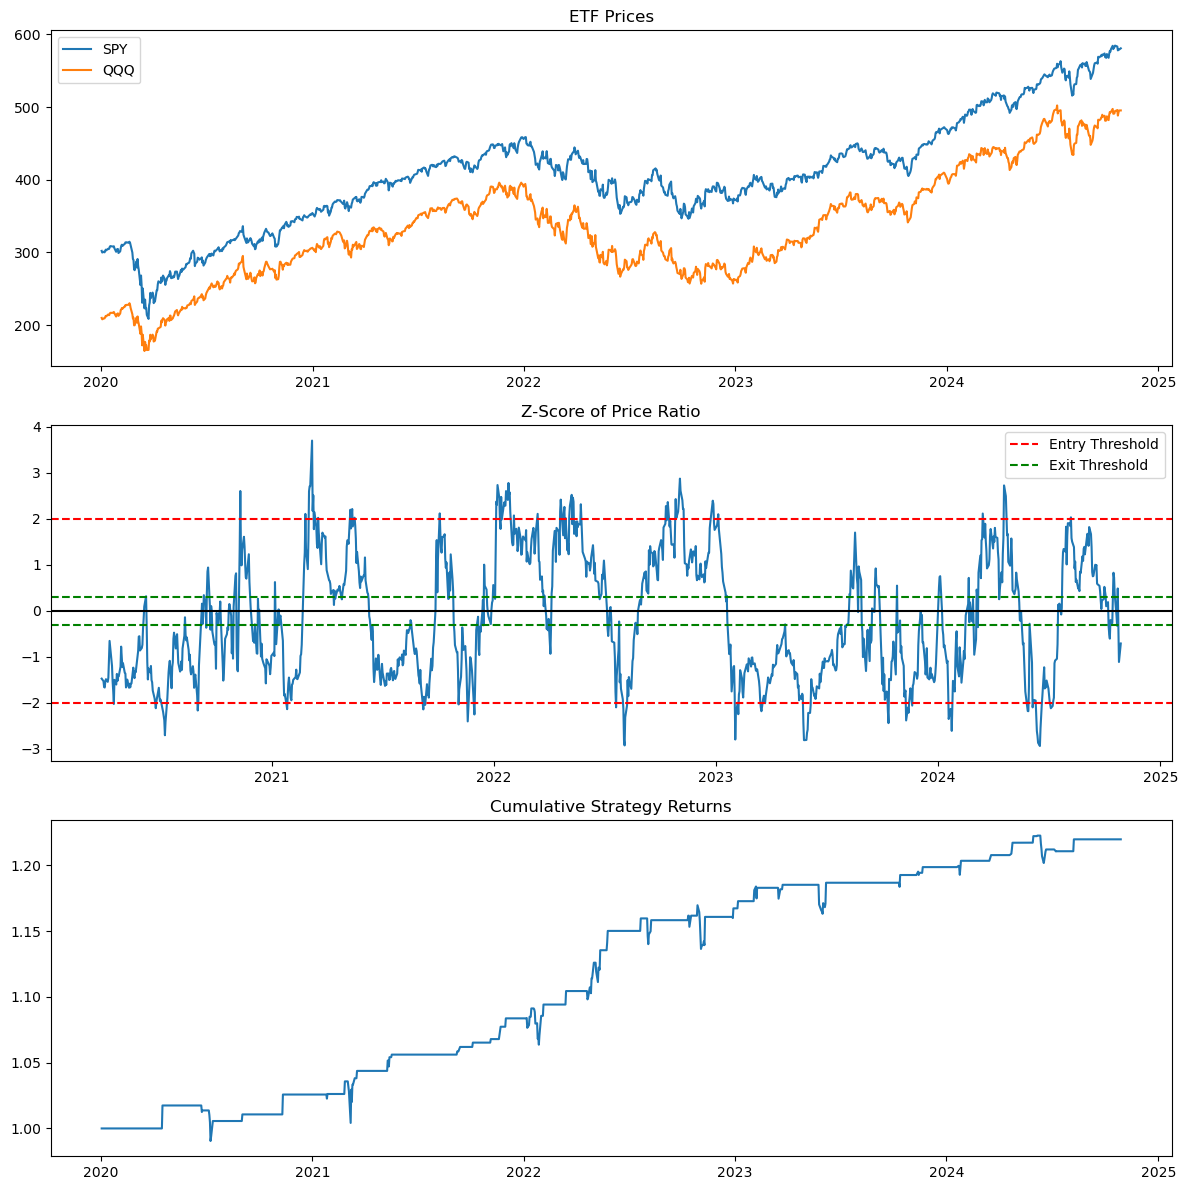

In [35]:
# Example with XLF (Financial Select Sector SPDR) and XLK (Technology Select Sector SPDR)
trader = PairsTrader(
    symbol1='SPY',
    symbol2='QQQ',
    start_date='2020-01-01',
    end_date=datetime.today().strftime('%Y-%m-%d'),
    entry_threshold=2.0,
    exit_threshold=0.3,
    lookback_period=60
)

# Run analysis
trader.calculate_spread()
trader.generate_signals()
trader.backtest_strategy()

# Display performance metrics
returns = trader.data['strategy_return'].dropna()
print("\nStrategy Performance Metrics:")
print(f"Sharpe Ratio: {np.sqrt(252) * returns.mean() / returns.std():.2f}")
print(f"Total Return: {(trader.data['cumulative_return'].iloc[-1] - 1) * 100:.2f}%")
print(f"Max Drawdown: {(trader.data['cumulative_return'].div(trader.data['cumulative_return'].cummax()) - 1).min() * 100:.2f}%")

# Plot results
trader.plot_results()

In [36]:
class PairsTradeBacktester:
    def __init__(self, symbol1, symbol2, start_date, end_date,
                 entry_threshold=2.0, exit_threshold=0.5,
                 lookback_period=30, transaction_cost=0.001):
        self.symbol1 = symbol1
        self.symbol2 = symbol2
        self.entry_threshold = entry_threshold
        self.exit_threshold = exit_threshold
        self.lookback_period = lookback_period
        self.transaction_cost = transaction_cost
        
        # Get data and initialize results
        self.data = self._get_price_data(start_date, end_date)
        self.trades = pd.DataFrame(columns=['entry_date', 'exit_date', 'position', 'profit_loss'])
        self.performance_metrics = {}
    
    def _get_price_data(self, start_date, end_date):
        """Download and prepare price data"""
        # Download data for both ETFs
        df1 = yf.download(self.symbol1, start=start_date, end=end_date)['Adj Close']
        df2 = yf.download(self.symbol2, start=start_date, end=end_date)['Adj Close']
        
        # Combine into a single dataframe
        df = pd.DataFrame({
            f'{self.symbol1}_price': df1,
            f'{self.symbol2}_price': df2
        })
        return df.dropna()
    
    def calculate_signals(self):
        """Calculate trading signals and returns"""
        # Calculate ratio and z-score
        self.data['ratio'] = self.data[f'{self.symbol1}_price'] / self.data[f'{self.symbol2}_price']
        self.data['ratio_ma'] = self.data['ratio'].rolling(window=self.lookback_period).mean()
        self.data['ratio_std'] = self.data['ratio'].rolling(window=self.lookback_period).std()
        self.data['zscore'] = (self.data['ratio'] - self.data['ratio_ma']) / self.data['ratio_std']
        
        # Generate positions
        self.data['position'] = 0
        self.data.loc[self.data['zscore'] < -self.entry_threshold, 'position'] = 1  # Long spread
        self.data.loc[self.data['zscore'] > self.entry_threshold, 'position'] = -1  # Short spread
        self.data.loc[abs(self.data['zscore']) < self.exit_threshold, 'position'] = 0  # Exit
        
        # Calculate returns
        self.data['return_1'] = self.data[f'{self.symbol1}_price'].pct_change()
        self.data['return_2'] = self.data[f'{self.symbol2}_price'].pct_change()
        
        # Calculate strategy returns with transaction costs
        self.data['position_change'] = self.data['position'].diff().abs()
        self.data['transaction_costs'] = self.data['position_change'] * self.transaction_cost
        self.data['strategy_return'] = (self.data['position'].shift(1) * 
                                      (self.data['return_1'] - self.data['return_2'])) - \
                                      self.data['transaction_costs']
        
        # Calculate cumulative returns and drawdown
        self.data['cumulative_return'] = (1 + self.data['strategy_return']).cumprod()
        self.data['peak'] = self.data['cumulative_return'].expanding().max()
        self.data['drawdown'] = (self.data['cumulative_return'] - self.data['peak']) / self.data['peak']
    
    def get_performance_metrics(self):
        """Calculate and return performance metrics"""
        if 'strategy_return' not in self.data.columns:
            self.calculate_signals()
            
        returns = self.data['strategy_return'].dropna()
        
        # Calculate trade statistics
        trades = self.data[self.data['position_change'] > 0]
        winning_trades = len(returns[returns > 0])
        losing_trades = len(returns[returns <= 0])
        
        metrics = pd.Series({
            'Total Trades': len(trades),
            'Winning Trades': winning_trades,
            'Losing Trades': losing_trades,
            'Win Rate': winning_trades / (winning_trades + losing_trades),
            'Total Return': self.data['cumulative_return'].iloc[-1] - 1,
            'Avg Return Per Trade': returns.mean(),
            'Avg Winning Trade': returns[returns > 0].mean(),
            'Avg Losing Trade': returns[returns <= 0].mean(),
            'Profit Factor': abs(returns[returns > 0].sum() / returns[returns <= 0].sum()),
            'Max Drawdown': self.data['drawdown'].min()
        })
        
        return metrics
    
    def plot_results(self):
        """Plot strategy results"""
        if 'strategy_return' not in self.data.columns:
            self.calculate_signals()
            
        fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(15, 10))
        
        # Plot 1: Asset Prices (Normalized)
        norm_price1 = self.data[f'{self.symbol1}_price'] / self.data[f'{self.symbol1}_price'].iloc[0]
        norm_price2 = self.data[f'{self.symbol2}_price'] / self.data[f'{self.symbol2}_price'].iloc[0]
        ax1.plot(self.data.index, norm_price1, label=self.symbol1)
        ax1.plot(self.data.index, norm_price2, label=self.symbol2)
        ax1.set_title('Normalized Asset Prices')
        ax1.legend()
        
        # Plot 2: Z-Score and Trading Signals
        ax2.plot(self.data.index, self.data['zscore'])
        ax2.axhline(y=self.entry_threshold, color='r', linestyle='--', label='Entry Threshold')
        ax2.axhline(y=-self.entry_threshold, color='r', linestyle='--')
        ax2.axhline(y=self.exit_threshold, color='g', linestyle='--', label='Exit Threshold')
        ax2.axhline(y=-self.exit_threshold, color='g', linestyle='--')
        ax2.axhline(y=0, color='k', linestyle='-')
        ax2.set_title('Z-Score with Entry/Exit Thresholds')
        ax2.legend()

        # Plot 3: Cumulative Strategy Returns
        ax3.plot(self.data.index, self.data['cumulative_return'])
        ax3.set_title('Cumulative Strategy Returns')
        
        # Plot 4: Strategy Drawdown
        ax4.fill_between(self.data.index, self.data['drawdown'], 0, color='red', alpha=0.3)
        ax4.set_title('Strategy Drawdown')
        
        plt.tight_layout()
        plt.show()

[*********************100%***********************]  1 of 1 completed


[*********************100%***********************]  1 of 1 completed



Strategy Performance Metrics:
Total Trades            102.000000
Winning Trades           62.000000
Losing Trades           943.000000
Win Rate                  0.061692
Total Return              0.068096
Avg Return Per Trade      0.000094
Avg Winning Trade         0.015013
Avg Losing Trade         -0.000887
Profit Factor             1.113193
Max Drawdown             -0.111181


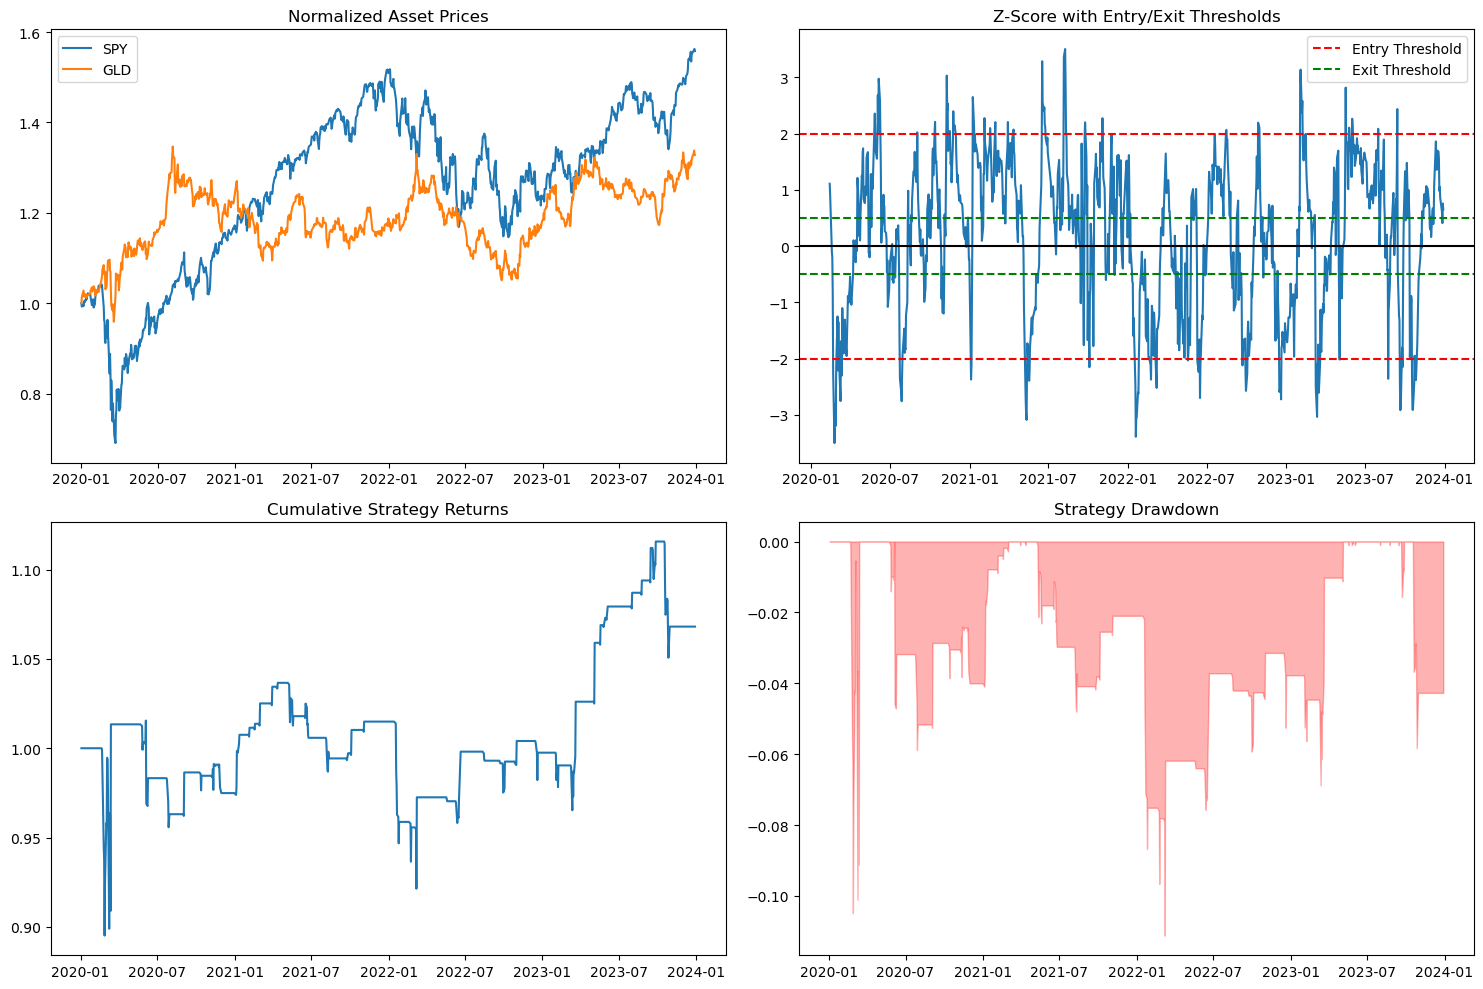

In [38]:
# Initialize backtester
backtester = PairsTradeBacktester(
    symbol1='SPY',
    symbol2='GLD',
    start_date='2020-01-01',
    end_date='2024-01-01',
    entry_threshold=2.0,
    exit_threshold=0.5,
    lookback_period=30
)

# Calculate signals and run backtest
backtester.calculate_signals()

# Get and print performance metrics
metrics = backtester.get_performance_metrics()
print("\nStrategy Performance Metrics:")
print(metrics.to_string())

# Plot results
backtester.plot_results()

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


Optimizing parameters...

Best Parameters: {'lookback_period': 60, 'entry_threshold': 2.0, 'exit_threshold': 0.3}

Strategy Performance with Optimized Parameters:
Total Return     0.198564
Annual Return    0.046463
Sharpe Ratio     1.168782
Max Drawdown    -0.030479
Win Rate         0.064677


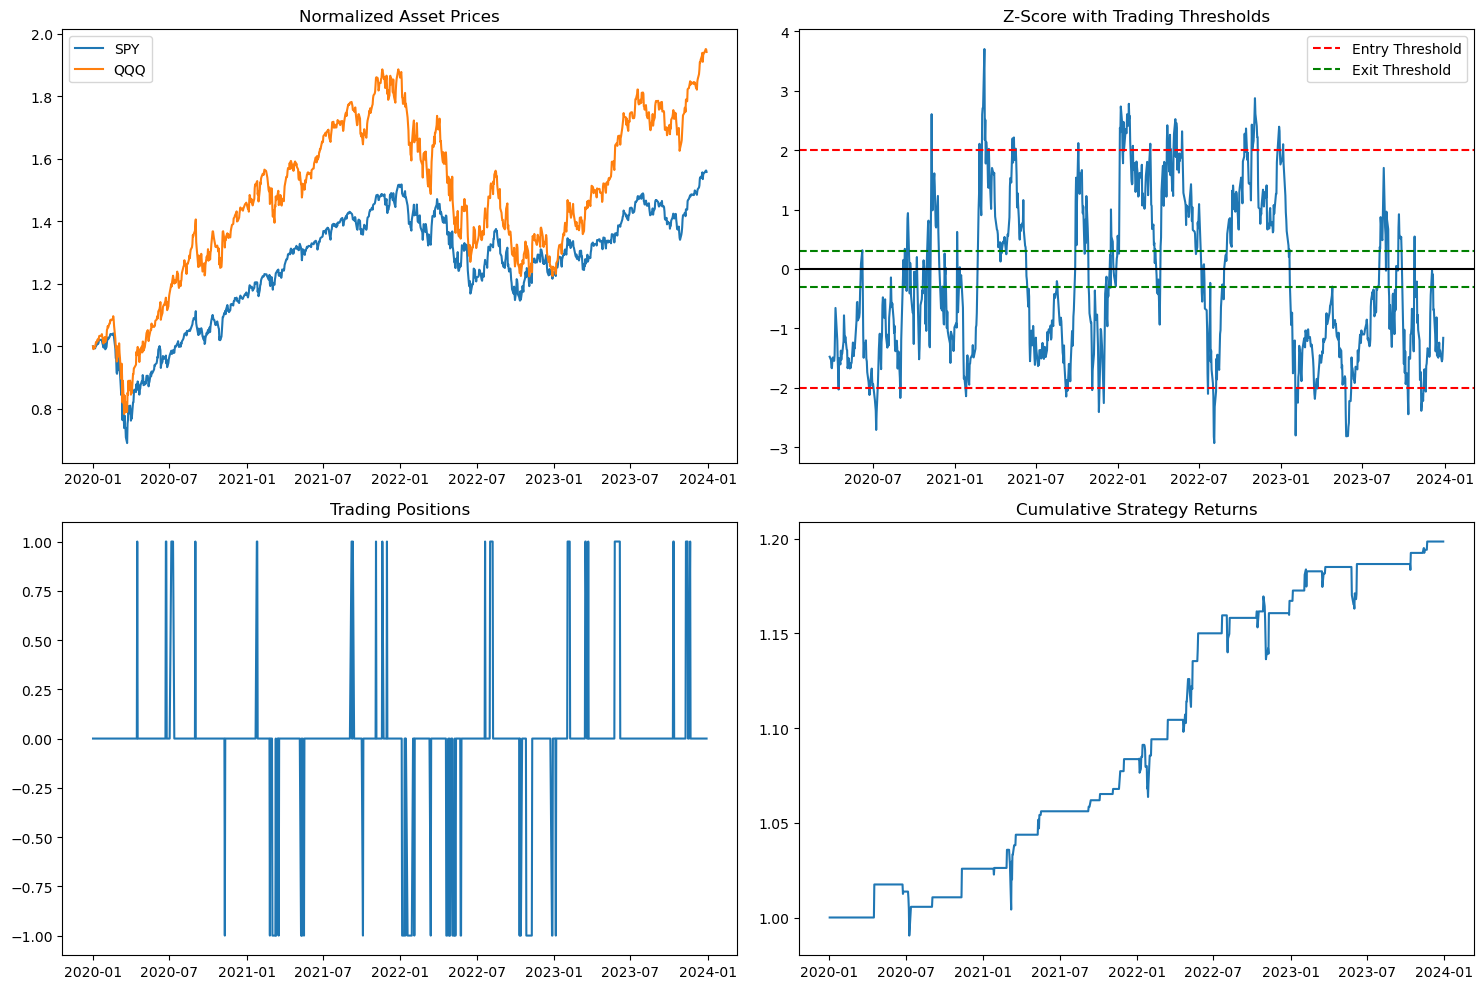

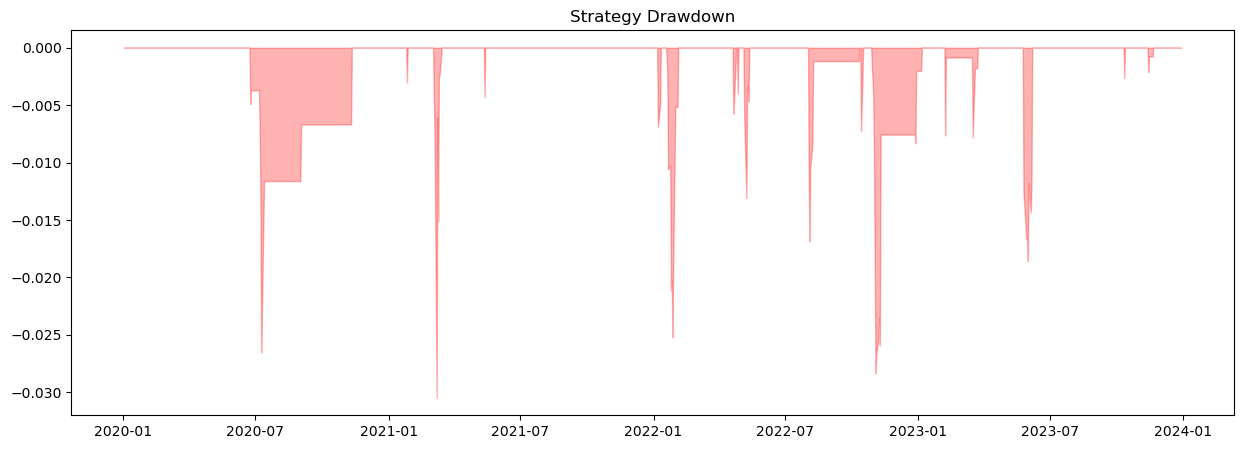

In [33]:
class MLPairsTrader:
    def __init__(self, symbol1, symbol2, start_date, end_date):
        self.symbol1 = symbol1
        self.symbol2 = symbol2
        self.data = self._get_price_data(start_date, end_date)
        self.best_params = None
        self.cv_results = None
        
    def _get_price_data(self, start_date, end_date):
        """Download and prepare price data with consistent column naming"""
        df1 = yf.download(self.symbol1, start=start_date, end=end_date)['Adj Close']
        df2 = yf.download(self.symbol2, start=start_date, end=end_date)['Adj Close']
        
        # Create DataFrame with consistent column naming
        df = pd.DataFrame({
            f'{self.symbol1}_price': df1,
            f'{self.symbol2}_price': df2
        })
        return df.dropna()
    
    def optimize_parameters(self, cv_splits=5):
        """Optimize strategy parameters using time series cross-validation"""
        # Define parameter grid
        param_grid = {
            'lookback_period': range(10, 101, 10),  # 10 to 100 in steps of 10
            'entry_threshold': np.arange(1.5, 4.1, 0.5),  # 1.5 to 4.0 in steps of 0.5
            'exit_threshold': np.arange(0.3, 2.1, 0.2)  # 0.3 to 2.0 in steps of 0.2
        }
        
        # Create time series split
        tscv = TimeSeriesSplit(n_splits=cv_splits)
        
        # Define scoring function
        def custom_scorer(y_true, y_pred):
            returns = pd.Series(y_pred)
            if len(returns) == 0 or returns.std() == 0:
                return -np.inf
            
            sharpe = np.sqrt(252) * returns.mean() / returns.std()
            total_return = (1 + returns).prod() - 1
            max_dd = (1 + returns).cumprod().div((1 + returns).cumprod().cummax()).min() - 1
            
            return sharpe * 0.4 + total_return * 0.3 + (-max_dd) * 0.3
        
        # Initialize results storage
        best_score = -np.inf
        best_params = None
        cv_results = []
        
        # Perform grid search
        for params in self._generate_param_combinations(param_grid):
            fold_scores = []
            
            for train_idx, test_idx in tscv.split(self.data):
                test_data = self.data.iloc[test_idx].copy()
                results = self._calculate_signals_with_params(test_data, params)
                
                if 'strategy_return' in results.columns:
                    returns = results['strategy_return'].dropna()
                    if len(returns) > 0:
                        score = custom_scorer(None, returns)
                        fold_scores.append(score)
            
            if fold_scores:
                avg_score = np.mean(fold_scores)
                cv_results.append({
                    'params': params,
                    'score': avg_score,
                    'fold_scores': fold_scores
                })
                
                if avg_score > best_score:
                    best_score = avg_score
                    best_params = params
        
        self.best_params = best_params
        self.cv_results = cv_results
        return best_params
    
    def _generate_param_combinations(self, param_grid):
        """Generate all combinations of parameters"""
        import itertools
        keys = param_grid.keys()
        values = param_grid.values()
        return [dict(zip(keys, v)) for v in itertools.product(*values)]
    
    def _calculate_signals_with_params(self, data, params):
        """Calculate signals with specific parameters"""
        data = data.copy()
        
        # Calculate ratio and z-score
        data['ratio'] = data[f'{self.symbol1}_price'] / data[f'{self.symbol2}_price']
        data['ratio_ma'] = data['ratio'].rolling(window=params['lookback_period']).mean()
        data['ratio_std'] = data['ratio'].rolling(window=params['lookback_period']).std()
        data['zscore'] = (data['ratio'] - data['ratio_ma']) / data['ratio_std']
        
        # Generate positions
        data['position'] = 0
        data.loc[data['zscore'] < -params['entry_threshold'], 'position'] = 1
        data.loc[data['zscore'] > params['entry_threshold'], 'position'] = -1
        data.loc[abs(data['zscore']) < params['exit_threshold'], 'position'] = 0
        
        # Calculate returns
        data['return_1'] = data[f'{self.symbol1}_price'].pct_change()
        data['return_2'] = data[f'{self.symbol2}_price'].pct_change()
        data['strategy_return'] = data['position'].shift(1) * (data['return_1'] - data['return_2'])
        
        return data
    
    def plot_results(self, results=None):
        """Plot strategy results including prices, z-scores, positions, and returns"""
        if results is None and self.best_params is None:
            raise ValueError("Must either provide results or run optimize_parameters first")
        
        if results is None:
            results = self._calculate_signals_with_params(self.data, self.best_params)
        
        # Create subplots
        fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(15, 10))
        
        # Plot 1: Normalized Asset Prices
        norm_price1 = results[f'{self.symbol1}_price'] / results[f'{self.symbol1}_price'].iloc[0]
        norm_price2 = results[f'{self.symbol2}_price'] / results[f'{self.symbol2}_price'].iloc[0]
        ax1.plot(results.index, norm_price1, label=self.symbol1)
        ax1.plot(results.index, norm_price2, label=self.symbol2)
        ax1.set_title('Normalized Asset Prices')
        ax1.legend()
        
        # Plot 2: Z-Score and Trading Signals
        ax2.plot(results.index, results['zscore'])
        if self.best_params:
            ax2.axhline(y=self.best_params['entry_threshold'], color='r', linestyle='--', label='Entry Threshold')
            ax2.axhline(y=-self.best_params['entry_threshold'], color='r', linestyle='--')
            ax2.axhline(y=self.best_params['exit_threshold'], color='g', linestyle='--', label='Exit Threshold')
            ax2.axhline(y=-self.best_params['exit_threshold'], color='g', linestyle='--')
        ax2.axhline(y=0, color='k', linestyle='-')
        ax2.set_title('Z-Score with Trading Thresholds')
        ax2.legend()
        
        # Plot 3: Trading Positions
        ax3.plot(results.index, results['position'])
        ax3.set_title('Trading Positions')
        
        # Plot 4: Cumulative Returns
        cumulative_returns = (1 + results['strategy_return'].fillna(0)).cumprod()
        ax4.plot(results.index, cumulative_returns)
        ax4.set_title('Cumulative Strategy Returns')
        
        plt.tight_layout()
        plt.show()
        
        # Additional plot for drawdown
        plt.figure(figsize=(15, 5))
        drawdown = cumulative_returns / cumulative_returns.cummax() - 1
        plt.fill_between(results.index, drawdown, 0, color='red', alpha=0.3)
        plt.title('Strategy Drawdown')
        plt.show()

# Example usage

# Initialize ML trader
ml_trader = MLPairsTrader(
    symbol1='SPY',
    symbol2='QQQ',
    start_date='2020-01-01',
    end_date='2024-01-01'
)

# Optimize parameters
print("Optimizing parameters...")
best_params = ml_trader.optimize_parameters(cv_splits=5)
print("\nBest Parameters:", best_params)

# Calculate signals with optimized parameters
results = ml_trader._calculate_signals_with_params(ml_trader.data, best_params)

# Calculate performance metrics
returns = results['strategy_return'].dropna()
metrics = pd.Series({
    'Total Return': (1 + returns).prod() - 1,
    'Annual Return': (1 + returns).prod() ** (252/len(returns)) - 1,
    'Sharpe Ratio': np.sqrt(252) * returns.mean() / returns.std(),
    'Max Drawdown': (1 + returns).cumprod().div((1 + returns).cumprod().cummax()).min() - 1,
    'Win Rate': (returns > 0).mean()
})

print("\nStrategy Performance with Optimized Parameters:")
print(metrics.to_string())

# Plot the results
ml_trader.plot_results()